In [1]:
import xgboost as xgb
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geoplot as gplt
import geoplot.crs as gcrs
from sklearn.model_selection import train_test_split
import contextily as cx

In [2]:
data = pd.read_csv('../data/seattle_sample_3k.csv')

In [3]:
data = gpd.GeoDataFrame(data, crs="EPSG:32610", geometry=gpd.points_from_xy(x=data.UTM_X, y=data.UTM_Y))

In [4]:
data = data.to_crs(4326)

In [5]:
data['lat'] = data['geometry'].get_coordinates()['x']
data['lon'] = data['geometry'].get_coordinates()['y']

In [6]:
data['price'] = np.power(10, data['log_price']) / 10000

In [7]:
y = data.price
X = data[['bathrooms', 'sqft_living', 'sqft_lot', 'grade', 'condition', 'waterfront', 'view', 'age', 'UTM_X', 'UTM_Y']]
loc = data[['lat','lon']]

In [8]:
X_train, X_temp, y_train, y_temp, loc_train, loc_temp = train_test_split(X, y, loc, train_size=0.8, random_state=42)

In [9]:
X_calib, X_test, y_calib, y_test, loc_calib, loc_test = train_test_split(X_temp, y_temp, loc_temp, train_size=0.5, random_state=42)


In [10]:
model = xgb.XGBRegressor(n_estimators=500, max_depth=3, min_child_weight=1.0, colsample_bytree=1.0)

In [11]:
model.fit(X_train, y_train)

AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=1.0, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [12]:
model.score(X_test, y_test)

0.8705986887146308

In [13]:
from GeoConformal import GWQRBasedGeoConformalSpatialRegression

In [14]:
geocp = GWQRBasedGeoConformalSpatialRegression(predict_f=model.predict, nonconformity_score_f=None, miscoverage_level=0.1, alpha=8, coord_calib=loc_calib.values, coord_test=loc_test.values, x_calib=X_calib, y_calib=y_calib, x_test=X_test, y_test=y_test)

In [15]:
results = geocp.analyze()

100%|██████████| 300/300 [03:17<00:00,  1.52it/s]


In [16]:
results.coverage_probability

0.77

In [17]:
results.geo_uncertainty.mean() / 2

13.087598934702086

In [18]:
geo_results = results.to_gpd()

In [19]:
geo_results

,geo_uncertainty,pred,upper_bound,lower_bound,k,beta,alpha,x,y,geometry
0,36.260954,86.552925,110.721931,74.460977,115.0,0.031004,99.999948,-122.178,47.6948,POINT (-122.17800 47.69480)
1,18.988019,26.823208,37.159434,18.171415,99.0,0.041172,99.999948,-122.364,47.5030,POINT (-122.36400 47.50300)
2,16.977171,45.883007,49.430724,32.453553,115.0,0.023329,99.999948,-122.360,47.5659,POINT (-122.36000 47.56590)
3,16.891720,35.864384,46.985851,30.094131,15.0,0.020310,77.409624,-122.304,47.5880,POINT (-122.30400 47.58800)
4,22.304966,29.032578,37.908090,15.603124,175.0,0.051909,99.999948,-122.288,47.5412,POINT (-122.28800 47.54120)
...,...,...,...,...,...,...,...,...,...,...
295,25.810420,47.090702,52.437626,26.627206,99.0,0.062419,99.999948,-122.127,47.6557,POINT (-122.12700 47.65570)
296,9.542308,25.835550,27.235834,17.693526,114.0,0.004836,99.999948,-122.242,47.2630,POINT (-122.24200 47.26300)
297,46.937490,91.125793,117.788853,70.851363,176.0,0.028739,99.999948,-122.405,47.6420,POINT (-122.40500 47.64200)
298,28.088338,65.963219,83.853189,55.764851,159.0,0.052507,99.999948,-122.359,47.6797,POINT (-122.35900 47.67970)


<GeoAxes: >

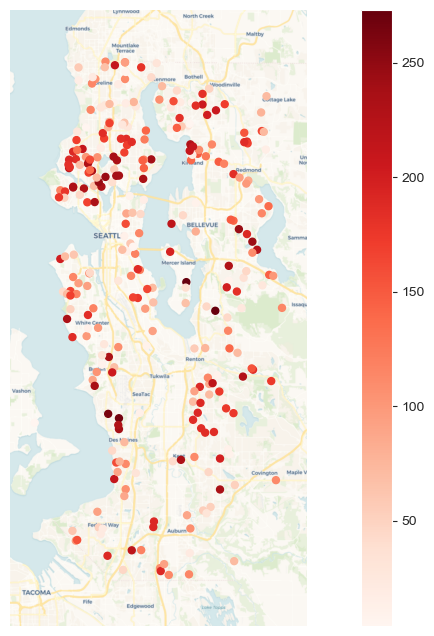

In [20]:
utm = gcrs.WebMercator()

ax = gplt.webmap(geo_results, projection=utm, figsize=(14, 8), provider=cx.providers.CartoDB.Voyager)

gplt.pointplot(geo_results, hue='k', cmap='Reds', legend=True, ax=ax)

In [18]:
from GeoConformal import GeoConformalSpatialRegression

In [19]:
geocp_spatial_std = GeoConformalSpatialRegression(predict_f=model.predict, nonconformity_score_f=None, miscoverage_level=0.1, bandwidth=0.15, coord_calib=loc_calib.values, coord_test=loc_test.values, X_calib=X_calib, y_calib=y_calib, X_test=X_test, y_test=y_test)

In [20]:
results_std = geocp_spatial_std.analyze()

In [21]:
results_std.coverage_probability

0.9366666666666666

In [22]:
results_std.geo_uncertainty.mean()

19.452105716929108

In [13]:
from GeoConformal import LSCP

In [14]:
lscp = LSCP(predict_f=model.predict, nonconformity_score_f=None, miscoverage_level=0.1, coord_calib=loc_calib.values, coord_test=loc_test.values, x_calib=X_calib, y_calib=y_calib, x_test=X_test, y_test=y_test)

In [15]:
results_lscp = lscp.analyze()

100%|██████████| 300/300 [00:24<00:00, 12.28it/s]


In [16]:
results_lscp.coverage_probability

0.8433333333333334

In [17]:
results_lscp.geo_uncertainty.mean() / 2

16.772363764603462